In [14]:
import requests
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from torchvision import models
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving Tenis-Nike-Air-Max-Nuaxis-Cinza-Esportivo-Masculino-.png to Tenis-Nike-Air-Max-Nuaxis-Cinza-Esportivo-Masculino- (2).png


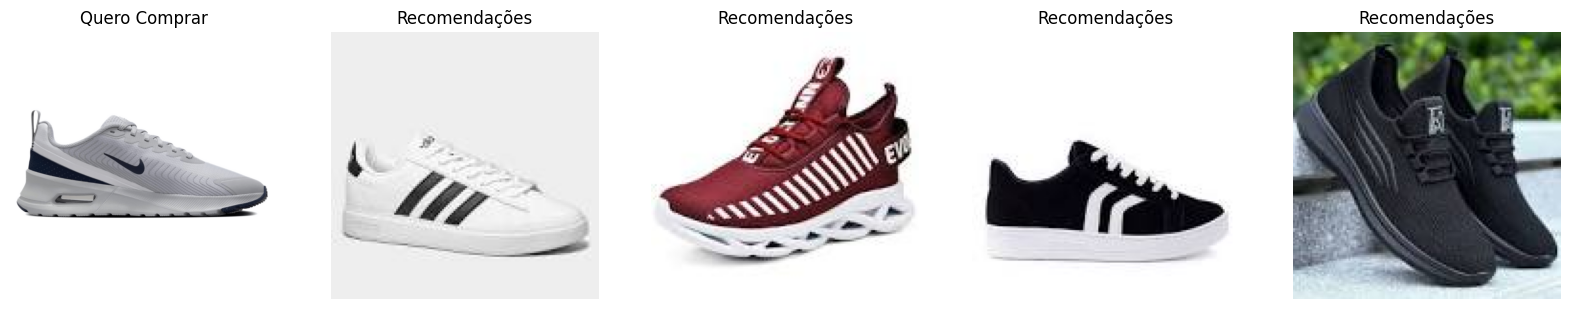

In [15]:
def search_images(num_results=10):
    search_url = "https://www.google.com/search?q=tênis&tbm=isch"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(search_url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    image_elements = soup.find_all("img", limit=num_results+1)
    image_urls = [img["src"] for img in image_elements[1:]]  # Ignorar o primeiro resultado, pois pode ser um ícone
    return image_urls

# Modelo pré-treinado para extração de features (ResNet50)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove a última camada FC
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_image_embedding(image):
    image = image.convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().numpy()
    return embedding.flatten()

def find_similar_images(reference_embedding, candidate_urls, top_n=4):
    candidate_embeddings = [get_image_embedding(Image.open(BytesIO(requests.get(url).content))) for url in candidate_urls]
    similarities = cosine_similarity([reference_embedding], candidate_embeddings)[0]
    ranked_urls = [url for _, url in sorted(zip(similarities, candidate_urls), reverse=True)][:top_n]
    return ranked_urls

def display_images(reference_image, similar_images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    # Exibir imagem de referência
    axes[0].imshow(reference_image)
    axes[0].set_title("Quero Comprar")
    axes[0].axis("off")

    # Exibir imagens recomendadas
    for i, img_url in enumerate(similar_images):
        img = Image.open(BytesIO(requests.get(img_url).content))
        axes[i+1].imshow(img)
        axes[i+1].set_title("Recomendações")
        axes[i+1].axis("off")

    plt.show()

# Upload de imagem pelo usuário
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
reference_image = Image.open(image_path)
reference_embedding = get_image_embedding(reference_image)

# Busca imagens similares
image_urls = search_images()

if image_urls:
    similar_images = find_similar_images(reference_embedding, image_urls, top_n=4)
    display_images(reference_image, similar_images)
else:
    print("Nenhuma imagem encontrada.")